# Supermarket Items Order Model

This notebook is used as an experimentation notebook to train a model that sorts items in a supermarket list in the most optimal pick-up order. 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
from datetime import datetime
import random
import seaborn as sns
import warnings
from IPython.display import clear_output
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import boto3
from botocore.exceptions import ClientError
import json

client = boto3.client("bedrock-runtime", region_name="eu-west-1")

import tensorflow as tf
import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Input, Flatten, Concatenate, Dropout
# from tensorflow.keras.models import Model

from tqdm.notebook import tqdm
from scipy.stats import uniform, randint, boxcox

pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

# Basic variables that are going to be used later
target_var = 'before'
id_var = '_id'

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
2024-11-18 07:21:08.269915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def create_proper_form_file(bad_file_name, target_file_name: str): 
    """Takes a backup GCP CS file and converts it to a proper json file. 
    Backups in Toto write each backed up object of a collection as a string. 
    The backup file, hence, does not contain heading and trailing array notations '[' and ']', 
    and does not contain commas to separate each row. 
    This method converts it.
    """
    with open(target_file_name, "w") as target_file: 
        target_file.write("[")
        
        previous_line = None
        
        with open(bad_file_name, 'r') as source_file: 
            for line in source_file: 
                if previous_line is not None: 
                    target_file.write(previous_line + ',\n')
                    
                previous_line = line
                
            if previous_line is not None: 
                target_file.write(previous_line + "\n")
                
        target_file.write("]")

In [6]:
def load_data(): 

    # Load the 'dirty' data
    archived_lists_filename = '/home/sagemaker-user/ml-notebooks/toto/20241117-archivedLists.json'
    game_examples_filename =  '/home/sagemaker-user/ml-notebooks/toto/20241117-trainingExamples.json'

    target_archived_list_filename = '/home/sagemaker-user/ml-notebooks/toto/20241117-archivedLists-cleaned.json'
    target_game_examples_filename = '/home/sagemaker-user/ml-notebooks/toto/20241117-trainingExamples-cleaned.json'

    # Clean up
    create_proper_form_file(archived_lists_filename, target_archived_list_filename)
    create_proper_form_file(game_examples_filename, target_game_examples_filename)

    # Load the data
    archived_lists = pd.read_json(target_archived_list_filename)
    game_examples = pd.read_json(target_game_examples_filename)

    # Drop ids
    archived_lists.drop(columns=[id_var, 'date'], inplace=True)
    game_examples.drop(columns=[id_var, 'date'], inplace=True)

    return archived_lists, game_examples

In [7]:
archived_lists, game_examples = load_data()

In [8]:
archived_lists.head(2)

,name,supermarketId,supermarketName,supermarketLocation,userIndex,listId
0,Eggs,1,Super Brugsen,Solrød Strand,6,834ac775-39a6-42a3-b2dd-86cca3e2ad1f
1,Bacon,1,Super Brugsen,Solrød Strand,8,834ac775-39a6-42a3-b2dd-86cca3e2ad1f


In [9]:
game_examples.head(2)

,item1,item2,label,supermarketId
0,Greek yogurt,Letmælk,after,3
1,Coffee N,Coffee,after,1


---
# Bedrock Experimentation

In [10]:
class Llama:

    model_id = "eu.meta.llama3-2-3b-instruct-v1:0"

    def invoke(self, prompt: str): 
        
        formatted_prompt = f"""
        <|begin_of_text|><|start_header_id|>user<|end_header_id|>
        {prompt}
        <|eot_id|>
        <|start_header_id|>assistant<|end_header_id|>
        """
        
        native_request = {
            "prompt": formatted_prompt,
            "max_gen_len": 2000,
            "temperature": 0,
        }
        
        # Convert the native request to JSON.
        request = json.dumps(native_request)
        
        try:
            # Invoke the model with the request.
            response = client.invoke_model(modelId=self.model_id, body=request)
        
            # Decode the response body.
            model_response = json.loads(response["body"].read())
            
            # Extract and print the response text.
            response_text = model_response["generation"]
            
            return response_text
        
        except (ClientError, Exception) as e:
            print(f"ERROR: Can't invoke '{self.model_id}'. Reason: {e}")
            exit(1)

In [11]:
class Claude: 

    model_id = 'eu.anthropic.claude-3-5-sonnet-20240620-v1:0'

    def invoke(self, prompt: str): 
        # Start a conversation with the user message.
        
        conversation = [
            {
                "role": "user",
                "content": [{"text": prompt}],
            }
        ]
        
        try:
            # Send the message to the model, using a basic inference configuration.
            response = client.converse(
                modelId=self.model_id,
                messages=conversation,
                inferenceConfig={"maxTokens": 2000, "temperature": 0, "topP": 0.9},
            )
        
            # Extract and print the response text.
            return response["output"]["message"]["content"][0]["text"]
        
        except (ClientError, Exception) as e:
            print(f"ERROR: Can't invoke '{self.model_id}'. Reason: {e}")
            exit(1)

In [12]:
import ast 

class ItemClassifier:

    categories = {
        'Produce': ['apples', 'bananas', 'lettuce', 'tomatoes', 'sweet potato', 'carrots'],
        'Dairy': ['milk', 'cheese', 'yogurt', 'butter', 'mozzarella', 'ricotta'],
        'Bakery': ['bread', 'bagels', 'muffins', 'cakes', 'wasa'],
        'Meat': ['chicken', 'beef', 'pork', 'sausage', 'medister', 'bacon'],
        'Seafood': ['salmon', 'tuna', 'shrimp', 'cod'],
        'Frozen Foods': ['ice cream', 'frozen pizza', 'frozen vegetables', 'frozen bread'],
        'Canned Goods': ['soup', 'beans', 'corn', 'tomato sauce'],
        'Pasta and Rice': ['spaghetti', 'penne', 'rice', 'couscous'],
        'Condiments and Sauces': ['ketchup', 'mustard', 'mayo', 'salad dressing'],
        'Oils and Vinegars': ['olive oil', 'vegetable oil', 'balsamic vinegar'],
        'Snacks': ['chips', 'pretzels', 'popcorn', 'nuts'],
        'Breakfast Foods': ['cereal', 'oatmeal', 'musli', 'pancake mix'],
        'Beverages': ['soda', 'juice', 'water', 'coffee', 'havremælk'],
        'Baking Supplies': ['flour', 'sugar', 'baking powder', 'vanilla extract'],
        'Spreads': ['jam', 'honey', 'peanut butter', 'nutella'],
        'Pet Supplies': ['dog food', 'cat litter', 'pet toys', 'dog bags'],
        'Personal Care': ['shampoo', 'soap', 'toothpaste', 'deodorant'],
        'Household Items': ['paper towels', 'toilet paper', 'trash bags', 'diapers'],
        'Deli': ['sliced meats', 'olives', 'hummus', 'prepared salads'],
        'International Foods': ['salsa', 'soy sauce', 'curry paste', 'tortillas']
    }

    def categorize(self, item: str):
    
        prompt = f"""
        The following are supermarket items' categories. Each category has some examples of typical items that would belong in that category. 
        ---
        CATEGORIES:
        {self.categories}
        ---
        
        I need you to pick the most probable category for the following item: '{item}'.
        You can only consider categories that are among the ones that I provided above. 
        
        If you cannot assign a category, return the category 'unknown'.

        Only return the name of the category. Nothing else. 
        """
        
        return Claude().invoke(prompt)

    def batch_categorize(self, items, return_as: str = None): 

        instructions = """
        For each item, return a tuple in this format: 
        (item, category)
        'category' must be a string 
        'item' must be the item name

        Do not return any text expect the list of tuples. The list of tuples must be formatted as follows: 
        [tuple1, tuple2, ...]
        """

        if return_as == 'array': 
            instructions = """
            Return the categories as a list. 
            Do not return any text expect the list of categories, which must be formatted as follows: 
            ['category1', 'category2', ...]
            """
        elif return_as == 'dict': 
            instructions = """
            Return the categories as a dict in this format: 
            {'item1': 'category_of_item1', 'item2': 'category_of_item2', ...}

            Do not return any text expect the dict as specified above. 
            """

        items_string = ", ".join(items)
    
        prompt = f"""
        The following are supermarket items' categories. Each category has some examples of typical items that would belong in that category. 
        ---
        CATEGORIES:
        {self.categories}
        ---
        
        I need you to pick the most probable category for the following items.
        ---
        ITEMS:
        [{items_string}].
        ---
        You can only consider categories that are among the ones that I provided above. 
        
        If you cannot assign a category, return the category 'unknown'.

        {instructions}
        """
        
        result = Claude().invoke(prompt)

        
        if return_as == 'array' or return_as == 'dict': 
            return ast.literal_eval(result)
        
        return result
        

In [13]:
ItemClassifier().categorize('eggs')

'Dairy'

In [14]:
ItemClassifier().batch_categorize(['eggs', 'nutella', 'peanut butter', 'letmælk', 'latte', 'medister', 'bacon i tern', 'bacon', 'pesto'], return_as='dict')

{'eggs': 'Dairy',
 'nutella': 'Spreads',
 'peanut butter': 'Spreads',
 'letmælk': 'Dairy',
 'latte': 'Beverages',
 'medister': 'Meat',
 'bacon i tern': 'Meat',
 'bacon': 'Meat',
 'pesto': 'Condiments and Sauces'}

---
# Data Preparation & Feature Engineering

## Uniforming Datasets

In [15]:
def convert_archived_lists_to_examples(dataset):
    
    results = []
    
    for list_id, group in dataset.groupby("listId"):
        # Sort the group by userIndex to get the pickup order
        sorted_group = group.sort_values("userIndex")
    
        # Get all possible pairs of items in the sorted order
        for (i, row1), (j, row2) in combinations(sorted_group.iterrows(), 2):
            
            item1, item2 = row1["name"], row2["name"]
            supermarket_id = row1["supermarketId"]
            
            # Determine if item1 was picked "before" or "after" item2 based on userIndex
            if row1["userIndex"] < row2["userIndex"]:
                label = 1
            else:
                label = 0
    
            # Append the result as a new row
            results.append({
                "item1": item1,
                "item2": item2,
                "before": label,
                "supermarket_id": supermarket_id, 
                # 'list_id': list_id
            })
    
    return pd.DataFrame(results)

In [16]:
def prepare_game_examples(dataset): 

    df = dataset.copy()

    df['before'] = df['label'].apply(lambda label: 1 if label == 'before' else 0)
    df['supermarket_id'] = df['supermarketId']
    df.drop(columns=['supermarketId', 'label'], inplace=True)

    return df

In [17]:
def unite_and_balance_training_examples(archived_lists=archived_lists, game_examples=game_examples): 
    
    # 1. Convert the archived lists to pairs of training examples
    ex1 = convert_archived_lists_to_examples(archived_lists)

    # 2. Prepare the game examples
    ex2 = prepare_game_examples(game_examples)

    # 3. Unite the two
    df = pd.concat([ex1, ex2], axis=0)

    # 4. Rebalance the dataset: for each pair (item1, item2) with before = 1, generate one (item2, item1) with before = 0
    # Otherwise I have an extremely unbalanced dataset
    df_before = df[df["before"] == 1]
    df_swapped = df_before.copy()
    df_swapped["item1"], df_swapped["item2"] = df_before["item2"], df_before["item1"]
    df_swapped["before"] = 0

    # 5. Unite
    return pd.concat([df, df_swapped], ignore_index=True, axis=0)

<Axes: xlabel='before', ylabel='count'>

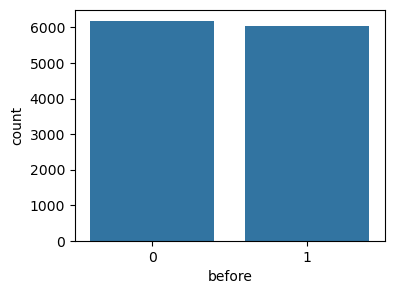

In [18]:
df = unite_and_balance_training_examples()
plt.figure(figsize=(4, 3))
sns.countplot(df, x='before')

## Data Cleaning

In [19]:
def remove_useless_words(df):
    """Removes words that are considered useless (e.g. 'c', 'big', 'for', etc..)
    """
    useless_words = ['c', 'n', 'noah', 'for', 'us', 'x2', 'big', 'pack', 'greek', 'or', 'something', 'caro',  'sweet', 'p', 'small', 'barista', 'dinner']

    # Define the cleaning function for each item1 value
    def remove_useless_words(text):
        
        words = text.split()  
        
        # Filter out any words that are in the useless_words list
        cleaned_words = [word for word in words if word.lower() not in useless_words]
        
        return ' '.join(cleaned_words)  # Join the remaining words back into a single string

    df['item1'] = df['item1'].apply(remove_useless_words)
    df['item2'] = df['item2'].apply(remove_useless_words)

    return df

In [20]:
def remove_rows_with_long_items(df):
    # Filter rows where item1 or item2 has 3 or fewer words
    df_filtered = df[df["item1"].apply(lambda x: len(x.split()) < 3)]
    df_filtered = df_filtered[df_filtered["item2"].apply(lambda x: len(x.split()) < 3)]
    return df_filtered

In [21]:
def lower_case_of_items(df):
    df["item1"] = df["item1"].str.lower()
    df["item2"] = df["item2"].str.lower()

    return df
    

In [127]:
def remove_conflicts(df):
    """Removes all pairs of rows where the label is conflicting, for the same items.
    Only the rows with the dominant label are kept. 
    So if there are 6 rows for the pair (i1, i2), 4 of which with label before=0 and 2 with label before=1, the ones with label before=0 are kept. 
    The other 2 rows will have their label changed to 0. 
    """
    # Find all pair of rows with inconsistent label
    incoherent_rows = df.groupby(['item1', 'item2']).filter(lambda x : x['before'].nunique() > 1)

    # Get the value counts
    incoherent_counts = incoherent_rows.groupby(['item1', 'item2'])['before'].value_counts()
    incoherent_counts = pd.DataFrame(incoherent_counts.reset_index(name='count'))
    
    # Drop the ones with lower count 
    incoherent_counts = incoherent_counts.sort_values("count", ascending=False).drop_duplicates(subset=["item1", "item2"])

    incoherent_counts_dict = {
        (row['item1'], row['item2']): row.drop(['item1', 'item2']).to_dict() 
        for _, row in incoherent_counts.iterrows()
    }

    # Define a cleaning function
    def fix_label(row): 
        fix = incoherent_counts_dict.get((row['item1'], row['item2']), None)

        if fix is not None: 
            return fix['before']

        return row['before']

    df['before'] = df.apply(fix_label, axis=1)

    return df
    

In [154]:
def clean_data(df):
    return remove_conflicts(
        lower_case_of_items(
            remove_empty_rows(
                remove_rows_with_long_items(
                    remove_useless_words(df)
                )
            )
        )
    )

In [93]:
def remove_empty_rows(df):
    """Removes the rows where either the item1 or item2 are empty as a result or previous cleaning or transformation steps
    """

    return df[(df["item1"] != "") & (df["item2"] != "")]

In [94]:
df_cleaned = clean_data(df.copy())
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11589 entries, 0 to 12228
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   item1           11589 non-null  object
 1   item2           11589 non-null  object
 2   before          11589 non-null  int64 
 3   supermarket_id  11589 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 452.7+ KB


## Filtering
We're only going to train a model on supermarket 1. There's not enough data in general on other supermarkets. 

In [30]:
def filter_supermarkets(df):
    return df[df['supermarket_id'] == 1].drop(columns='supermarket_id').reset_index(drop=True)

## Feature Engineering


In [31]:
def get_items_dictionnary(df):
    return pd.concat([pd.Series(df['item1']), pd.Series(df['item1'])]).unique()

### Item Category

In [32]:
def get_items_cat_dict(df):
    return ItemClassifier().batch_categorize(get_items_dictionnary(df), return_as='dict')
    

In [33]:
def add_items_category(dataset):

    df = dataset.copy()
    
    items_cat_dict = get_items_cat_dict(df)
    
    df['item1_cat'] = df['item1'].apply(lambda x : items_cat_dict.get(x, 'other').lower())
    df['item2_cat'] = df['item2'].apply(lambda x : items_cat_dict.get(x, 'other').lower())

    return df

In [34]:
def engineer_features(dataset): 
    return add_items_category(dataset)
    

## Encoding

In [50]:
def encode_items(df, trained_encoders = None, items_dict = None):

    if items_dict is None: 
        items_dict = get_items_dictionnary(df)
    items_cat_dict = get_items_cat_dict(df)
    item_categories = list(items_cat_dict.keys())

    if trained_encoders is None: 
        item_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        # cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        
        item_encoder.fit(items_dict.reshape(-1,1))
        # cat_encoder.fit(np.array(item_categories).reshape(-1,1))
    else:
        item_encoder = trained_encoders['item_encoder']
        # cat_encoder = trained_encoders['cat_encoder']

    encoded_df = df.copy()
    
    encoded_item1 = pd.DataFrame(item_encoder.transform(df[['item1']]), columns=items_dict).add_prefix('item1_')
    encoded_item2 = pd.DataFrame(item_encoder.transform(df[['item2']]), columns=items_dict).add_prefix('item2_')
    # encoded_cat1 = pd.DataFrame(item_encoder.transform(df[['item1_cat']]), columns=item_categories).add_prefix('cat1_')
    # encoded_cat2 = pd.DataFrame(item_encoder.transform(df[['item2_cat']]), columns=item_categories).add_prefix('cat2_')
    
    encoded_df.drop(columns=['item1', 'item2'], inplace=True)

    encoded_df = pd.concat([encoded_df, encoded_item1, encoded_item2], axis=1)
        
    return {
        "dataset": encoded_df, 
        "item_encoder": item_encoder, 
        'items_dict': items_dict
    }    

# Data Exploration

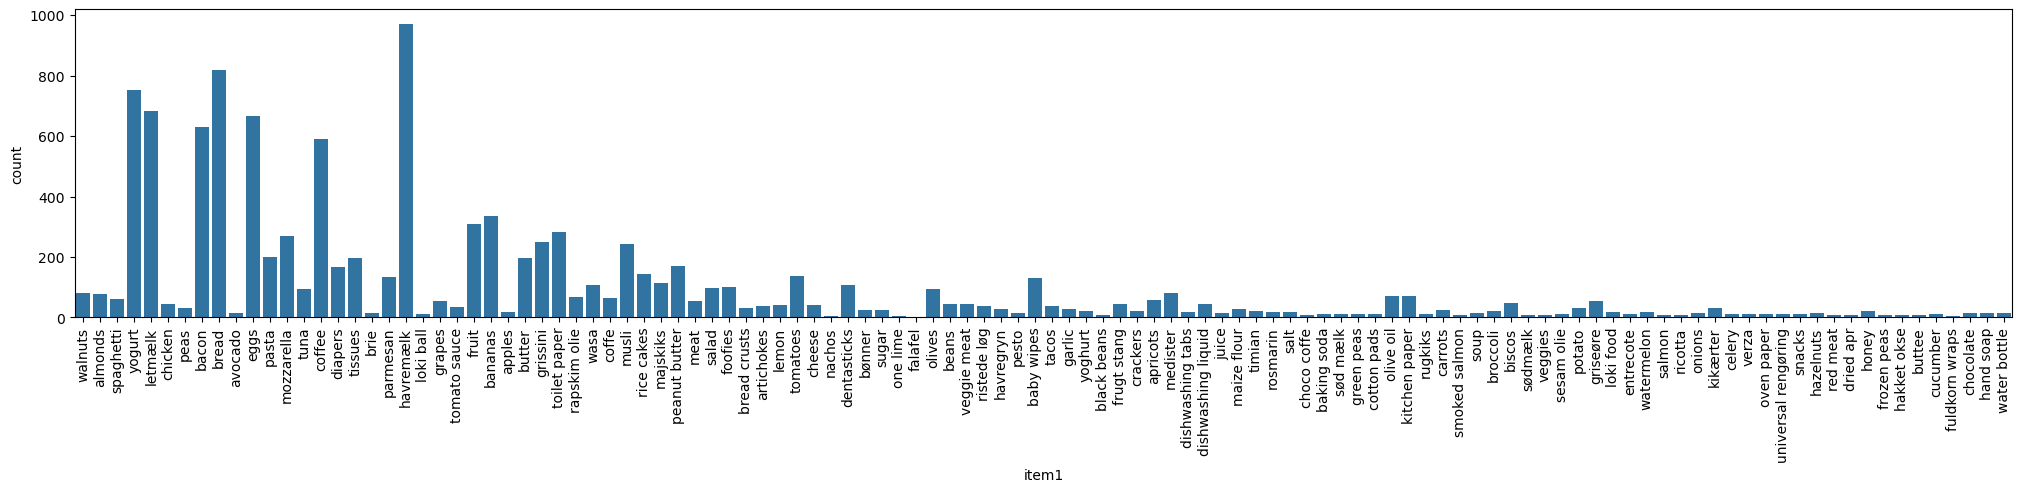

In [95]:
# 1. Get the dataset without encoding
eda_df = filter_supermarkets(
                clean_data(
                    unite_and_balance_training_examples()
                )
)

plt.figure(figsize=(25, 4))
sns.countplot(eda_df, x='item1')
plt.xticks(rotation=90)
plt.show()

Let's look for any incoherence in the data that might skew the results and get worse performances.<br>
 * Checking if there are pairs of the same (item1, item2) that have a conflicting label. *The analysis shows (in November 2024) that there are 7363 rows" that have incoherent labels for the same item pair. **We're going to keep the pairs with the dominant label**.* This is going to be added to the cleaning pipeline.

In [128]:
incoherent_rows = eda_df.groupby(['item1', 'item2']).filter(lambda x : x['before'].nunique() > 1)
print(f"Total size of the dataset: {len(eda_df)}")
print(f"Incoherent rows: {len(incoherent_rows)}")

Total size of the dataset: 11208
Incoherent rows: 7560



# Modelling


## Common Training functions


In [53]:
def train_model(model, model_name="Unamed Model", prepared_data=None):

    # 1. Prepare the data for Training
    if prepared_data is None: 
        print(f"Preparing data")
        
        preparation_result = encode_items(
            # engineer_features(
                filter_supermarkets(
                    clean_data(
                        unite_and_balance_training_examples()
                    )
                )   
            #)
        )
    else:
        preparation_result = prepared_data

    dataset = preparation_result['dataset']

    # 2. Split the data 
    X = dataset.drop(columns=[target_var]).to_numpy()
    y = dataset[target_var].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=32)

    # 3. Fit
    print(f"\nFitting {model_name}")
    
    model.fit(X_train, y_train)

    # 4. Score
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]

    scores = {
        'train': roc_auc_score(y_train, y_train_pred),
        'test': roc_auc_score(y_test, y_test_pred)
    }

    print(f"{model_name}: Train Score [{scores['train']}] - Test Score [{scores['test']}]")

    return {
        'model': model,
        'scores': scores, 
        'item_encoder': preparation_result['item_encoder'], 
        'items_dict': preparation_result['items_dict']
    }

In [155]:

prepared_data = encode_items(
    # engineer_features(
        filter_supermarkets(
            clean_data(
                unite_and_balance_training_examples()
            )
        )   
    # )
)

print(f"Prepared Data Shape: {prepared_data['dataset'].shape}")

Prepared Data Shape: (11208, 229)


In [156]:
prepared_data['dataset'].head()

,before,item1_walnuts,item1_almonds,item1_spaghetti,item1_yogurt,item1_letmælk,item1_chicken,item1_peas,item1_bacon,item1_bread,item1_avocado,item1_eggs,item1_pasta,item1_mozzarella,item1_tuna,item1_coffee,item1_diapers,item1_tissues,item1_brie,item1_parmesan,item1_havremælk,item1_loki ball,item1_grapes,item1_tomato sauce,item1_fruit,item1_bananas,item1_apples,item1_butter,item1_grissini,item1_toilet paper,item1_rapskim olie,item1_wasa,item1_coffe,item1_musli,item1_rice cakes,item1_majskiks,item1_peanut butter,item1_meat,item1_salad,item1_foofies,item1_bread crusts,item1_artichokes,item1_lemon,item1_tomatoes,item1_cheese,item1_nachos,item1_dentasticks,item1_bønner,item1_sugar,item1_one lime,item1_falafel,item1_olives,item1_beans,item1_veggie meat,item1_ristede løg,item1_havregryn,item1_pesto,item1_baby wipes,item1_tacos,item1_garlic,item1_yoghurt,item1_black beans,item1_frugt stang,item1_crackers,item1_apricots,item1_medister,item1_dishwashing tabs,item1_dishwashing liquid,item1_juice,item1_maize flour,item1_timian,item1_rosmarin,item1_salt,item1_choco coffe,item1_baking soda,item1_sød mælk,item1_green peas,item1_cotton pads,item1_olive oil,item1_kitchen paper,item1_rugkiks,item1_carrots,item1_smoked salmon,item1_soup,item1_broccoli,item1_biscos,item1_sødmælk,item1_veggies,item1_sesam olie,item1_potato,item1_griseøre,item1_loki food,item1_entrecote,item1_watermelon,item1_salmon,item1_ricotta,item1_onions,item1_kikærter,item1_celery,item1_verza,item1_oven paper,item1_universal rengøring,item1_snacks,item1_hazelnuts,item1_red meat,item1_dried apr,item1_honey,item1_frozen peas,item1_hakket okse,item1_buttee,item1_cucumber,item1_fuldkorn wraps,item1_chocolate,item1_hand soap,item1_water bottle,item2_walnuts,item2_almonds,item2_spaghetti,item2_yogurt,item2_letmælk,item2_chicken,item2_peas,item2_bacon,item2_bread,item2_avocado,item2_eggs,item2_pasta,item2_mozzarella,item2_tuna,item2_coffee,item2_diapers,item2_tissues,item2_brie,item2_parmesan,item2_havremælk,item2_loki ball,item2_grapes,item2_tomato sauce,item2_fruit,item2_bananas,item2_apples,item2_butter,item2_grissini,item2_toilet paper,item2_rapskim olie,item2_wasa,item2_coffe,item2_musli,item2_rice cakes,item2_majskiks,item2_peanut butter,item2_meat,item2_salad,item2_foofies,item2_bread crusts,item2_artichokes,item2_lemon,item2_tomatoes,item2_cheese,item2_nachos,item2_dentasticks,item2_bønner,item2_sugar,item2_one lime,item2_falafel,item2_olives,item2_beans,item2_veggie meat,item2_ristede løg,item2_havregryn,item2_pesto,item2_baby wipes,item2_tacos,item2_garlic,item2_yoghurt,item2_black beans,item2_frugt stang,item2_crackers,item2_apricots,item2_medister,item2_dishwashing tabs,item2_dishwashing liquid,item2_juice,item2_maize flour,item2_timian,item2_rosmarin,item2_salt,item2_choco coffe,item2_baking soda,item2_sød mælk,item2_green peas,item2_cotton pads,item2_olive oil,item2_kitchen paper,item2_rugkiks,item2_carrots,item2_smoked salmon,item2_soup,item2_broccoli,item2_biscos,item2_sødmælk,item2_veggies,item2_sesam olie,item2_potato,item2_griseøre,item2_loki food,item2_entrecote,item2_watermelon,item2_salmon,item2_ricotta,item2_onions,item2_kikærter,item2_celery,item2_verza,item2_oven paper,item2_universal rengøring,item2_snacks,item2_hazelnuts,item2_red meat,item2_dried apr,item2_honey,item2_frozen peas,item2_hakket okse,item2_buttee,item2_cucumber,item2_fuldkorn wraps,item2_chocolate,item2_hand soap,item2_water bottle
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [157]:
rf_model = train_model(RandomForestClassifier(), model_name="Random Forest", prepared_data=prepared_data)
xgb_model = train_model(XGBClassifier(), model_name="XGBoost", prepared_data=prepared_data)
# cat_boost_model = train_model(CatBoostClassifier(verbose=0), model_name="Cat Boost", prepared_data=prepared_data)
lgbm_model = train_model(LGBMClassifier(verbose=-1), model_name="Light GBM", prepared_data=prepared_data)
mlp_model = train_model(MLPClassifier(), model_name="MLP", prepared_data=prepared_data)


Fitting Random Forest
Random Forest: Train Score [1.0] - Test Score [0.9871459946086814]

Fitting XGBoost
XGBoost: Train Score [0.9516750904608142] - Test Score [0.934533414011026]

Fitting Light GBM
Light GBM: Train Score [0.94667583700574] - Test Score [0.9367640561670413]

Fitting MLP
MLP: Train Score [1.0] - Test Score [0.9894478700448849]


## Experiments

In [186]:

def mlp_grid_search(prepared_data=None):

    param_grid = {
        'hidden_layer_sizes': [(20, 20), (60, 60), (80, 80)],
        'activation': ['relu'],
        'alpha': [0.1, 1, 3]
    }

    mlp = MLPClassifier(max_iter=300)

    gs = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
    
    result = train_model(gs, model_name="Grid Search MLP", prepared_data=prepared_data)

    print("Best parameters found: ", gs.best_params_)
    print("Best score: ", gs.best_score_)

    result['model'] = gs.best_estimator_

    return result

In [187]:
mlp_best = mlp_grid_search(prepared_data=prepared_data)


Fitting Grid Search MLP
Grid Search MLP: Train Score [1.0] - Test Score [0.992413255472957]
Best parameters found:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (80, 80)}
Best score:  0.9829507140280785


## Final Model
#### Iteration 1
The best trained model of the first version of this model, obtained without considering Item Categories and without removing conflicting records was: <br>
Train Score [0.8328987977864004] - Test Score [**0.7889**227377472335]

#### Iteration 2
The second iteration introduces **removing conflicting records**. <br>
That reaches a slightly better performance: <br>
Train Score [0.99744506301024] - Test Score [**0.9851**178470581456]

In [188]:
final_model = train_model(MLPClassifier(alpha=0.1, hidden_layer_sizes=(80,80)), model_name="Chosen Model")

Preparing data

Fitting Chosen Model
Chosen Model: Train Score [1.0] - Test Score [0.9918409881096448]


# Inference

In [199]:
def inference_clean(df):
    """Cleans the data for the inference process
    """
    return lower_case_of_items(remove_useless_words(df))

In [208]:
example = ['Milk', 'mozzarella']
example_df = pd.DataFrame([example], columns=['item1', 'item2'])

encoded_example = encode_items(
    inference_clean(example_df), 
    trained_encoders={'item_encoder': final_model['item_encoder']}, 
    items_dict=final_model['items_dict']
)['dataset']

predicted_before = final_model['model'].predict_proba(encoded_example)[:,1]

print(f"Probability that '{example[0]}' comes before '{example[1]}': {predicted_before[0]}")

Probability that 'Milk' comes before 'mozzarella': 0.0028293366415902917
